# Introduction to PyTorch

You've implemented a lot of neural network functionalities, such as the forward/backward propagation, ReLU activation, Softmax, Mini-batch SGD, etc., using *Numpy*. You've also put significant effort into making your implementations efficient and fully vectorized in Hand-in assignment 1.

In this notebook, we're going to leave behind your beautiful codebase and instead migrate to a popular and powerful deep learning framework: *PyTorch*. **This make you get started to solve the first part of Hand-in assignment 2.**

### The motivation of using deep learning frameworks

- GPU acceleration: Your code can run on GPUs, enabling much faster training and inference.
- Automatic differentiation: This simplifies the implementation of complex neural networks and differentiable functions.

You can find more tutorials in the official website: https://docs.pytorch.org/tutorials

### Table of contents

This notebook contains two main parts:
1. **Part I, PyTorch Basics.** You will learn and work with PyTorch tensors.
2. **Part II, MNIST Classification.** You will implement a neural network using PyTorch for MNIST classification and aiming to get the same or comparable results to those from Assignment-1.

# Part I: PyTorch Basics

Note: Before running the following cells, you can manually switch to a GPU device on Colab by clicking `Runtime -> Change runtime type` and selecting `GPU` under `Hardware Accelerator`.

In [1]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt

print("PyTorch version: ", torch.__version__)

PyTorch version:  2.9.0+cpu


**Numpy array vs. Pytorch tensor**

PyTorch tensors are a specialized data structure that are very similar to NumPy’s ndarrays, except that tensors can run on GPUs and support automatic differentiation. If you’re already familiar with ndarray, you’ll be right at home with the Tensor API. If not, no worries—just follow along!

**Initialize a tensor**

In [2]:
data = [[1, 2], [3, 4]]
data_numpy = np.array(data)
print("data:", data)

# directly from the data
tensor_from_data = torch.tensor(data)
print(tensor_from_data)

data: [[1, 2], [3, 4]]
tensor([[1, 2],
        [3, 4]])


In [3]:
# from the Numpy ndarrays
tensor_from_numpy = torch.from_numpy(data_numpy)
print(tensor_from_data)

tensor([[1, 2],
        [3, 4]])


In [4]:
# initialize with random or constant values
rand_tensor = torch.rand(tensor_from_data.shape)
print(rand_tensor)
zero_tensor = torch.zeros(tensor_from_data.shape)
print(zero_tensor)
ones_tensor = torch.ones(tensor_from_data.shape)
print(ones_tensor)

tensor([[0.4144, 0.3424],
        [0.0614, 0.4504]])
tensor([[0., 0.],
        [0., 0.]])
tensor([[1., 1.],
        [1., 1.]])


**Tensor to numpy**

In [5]:
numpy_from_tensor = tensor_from_data.numpy()
numpy_from_tensor

array([[1, 2],
       [3, 4]])

**Attributes of a Tensor**

Tensor attributes describe their shape, datatype, and the device on which they are stored.

In [6]:
tensor1 = tensor_from_numpy.float()
tensor2 = rand_tensor.float()
tensor = torch.mul(tensor1, tensor2)
print(tensor)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

tensor([[0.4144, 0.6848],
        [0.1841, 1.8017]])
Shape of tensor: torch.Size([2, 2])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


**Tensor manipulation on the GPU deivce**

Note: the following example will be executed on GPU only if you have access to a GPU.

In [7]:
print("Use GPU: ", torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

tensor1_gpu = tensor1.to(device)
tensor2_gpu = tensor2.to(device)
tensor_gpu = torch.mul(tensor1_gpu, tensor2_gpu)
print("tensor device: ", tensor_gpu.device)

Use GPU:  False
tensor device:  cpu


You can also manually convert the tensor back to CPU.

In [8]:
tensor_cpu = tensor_gpu.cpu()
print("tensor device: ", tensor_cpu.device)

tensor device:  cpu


**Back-propagation with PyTorch's automatic differentiation engine**

Recall that training a neural network typically happens in three steps: *Forward Propagation*, *Backward Propagation*, and *Gradient Descent Optimization*.

During the forward pass in our model, PyTorch defines a computational graph, whose nodes are tensors and whose edges are the functions mapping one input tensor to another output tensor. By backpropagating this graph, we obtain the desired gradients which can be used to optimzie the parameters.

In [9]:
# state that we want to obtain the gradients of x
x1 = torch.tensor([2., 3.], requires_grad=True)
x2 = torch.tensor([1., 2.], requires_grad=True)

# run the forward pass and build the computational graph
z = torch.sum(x1 - x2)
print(f"Output of the forward pass: {z}\n")

# backpropagate the graph
z.backward()

print("First computation")
print(f"Gradient information of x1: {x1.grad}")
print(f"Gradient information of x2: {x2.grad}\n")

# Repeat the computations and backpropagate again, the gradients will be accumulated.
z = torch.sum(x1 - x2)

# backpropagate the graph
z.backward()

print("Second computation")
print(f"Gradient information of x1: {x1.grad}")
print(f"Gradient information of x2: {x2.grad}")

Output of the forward pass: 2.0

First computation
Gradient information of x1: tensor([1., 1.])
Gradient information of x2: tensor([-1., -1.])

Second computation
Gradient information of x1: tensor([2., 2.])
Gradient information of x2: tensor([-2., -2.])


To override the gradients, we have to set them to zero before running the forward pass.

In [10]:
# set the gradient of x to zero
x1.grad.zero_()
x2.grad.zero_()

# run the forward pass and build the computational graph
z = torch.sum(x1 - x2)

# backpropagate the graph
z.backward()

print(f"Gradient information of x1: {x1.grad}")
print(f"Gradient information of x2: {x2.grad}")

Gradient information of x1: tensor([1., 1.])
Gradient information of x2: tensor([-1., -1.])


If we want perform operations that should not be tracked by PyTorch, we can wrap them inside a torch.no_grad() clause.

In [11]:
with torch.no_grad():
    z = torch.sum(x1 - x2)
print(z)

tensor(2.)


### Linear regression example

Now we do something (slightly) more interesting. We consider linear regression using PyTorch. We study the model
\begin{equation*}
    y = \beta + \omega x + \epsilon,
\end{equation*}
where $\epsilon$ represents the noise term.

We generate training data $\{x_i, y_i\}_{i=1}^I$ with $I = 100$ data points from the model with the true parameters $\boldsymbol{\phi} = \begin{bmatrix} \beta & \omega\end{bmatrix}^\intercal = \begin{bmatrix} 0.3 & 0.1 \end{bmatrix}^\intercal$ and normally distributed noise $\epsilon \sim \mathcal{N}(0, 0.01^2)$. The inputs $x_i$ are sampled uniformly from the interval $[0,1]$.

We train the model on CPU by default.

In [12]:
phi_true = torch.tensor([0.3, 0.1])
n = 100

torch.manual_seed(1234)
x = torch.rand(n)
y = phi_true[0] + phi_true[1] * x + 0.01 * torch.randn(n)

We plot the data to see what it looks like.

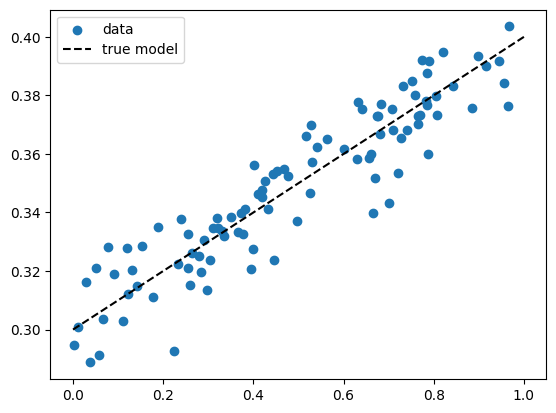

In [13]:
plt.scatter(x, y, label='data')
plt.plot([0, 1], [phi_true[0], phi_true[0] + phi_true[1]], 'k--', label='true model')
plt.legend()
plt.show()

We want to estimate the parameters $\boldsymbol{\phi} = \begin{bmatrix} \beta & \omega\end{bmatrix}^\intercal$ of the linear regression model based on the training data $\{x_i,y_i\}_{i=1}^I$. In addition, we proceed by implementing the mean squared error cost function $L[\boldsymbol{\phi}]$, where
\begin{equation*}
L[\boldsymbol{\phi}] = \frac{1}{I} \sum_{i=1}^I {(\beta + \omega x_i − y_i)}^2 = \frac{1}{I} {\|\mathbf{X} \boldsymbol{\phi} − \mathbf{y} \|}^2_2.
\end{equation*}
We multiply the input $\mathbf{X}$ with the variable $\boldsymbol{\phi}$, subtract the corresponding outputs, take the square, and finally average over all data samples.

Note: starting from Python 3.5, many NumPy-style operators—such as `@` for matrix multiplication and `**` for element-wise exponentiation—are supported at the language level and can be directly applied to tensor matrices as well.

Epoch 0001: training loss  1.354651
Epoch 0100: training loss  0.001509
Epoch 0200: training loss  0.000256
Epoch 0300: training loss  0.000126
Epoch 0400: training loss  0.000113
Epoch 0500: training loss  0.000111
Epoch 0600: training loss  0.000111
Epoch 0700: training loss  0.000111
Epoch 0800: training loss  0.000111
Epoch 0900: training loss  0.000111
Epoch 1000: training loss  0.000111


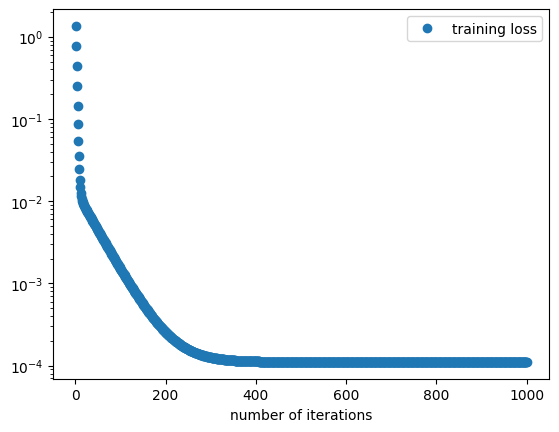

In [14]:
# define the initial model parameters as a column vector
phi = torch.ones(2, 1, requires_grad = True)

X = torch.stack([torch.ones(n), x], dim=1)
Y = y.view(-1, 1)

training_loss = []
for i in range(1000):
    # TODO -- compute the mean squared error (as loss) for the current parameters
    # Replace this line!
    # loss = (X @ phi).mean()
    loss = ((X @ phi - Y) ** 2).mean()
    # perform backpropagation
    loss.backward()
    training_loss.append(loss.item())
    if i == 0 or (i + 1) % 100 == 0:
        print(f"Epoch {i + 1:04d}: training loss {training_loss[-1]: 9.6f}")

    # perform a gradient descent step
    with torch.no_grad():
        phi -= 0.1 * phi.grad
    # reset the gradient information
    phi.grad.zero_()

plt.figure()
plt.plot(np.arange(1, len(training_loss) + 1), training_loss, 'o', label='training loss')
plt.yscale('log')
plt.xlabel('number of iterations')
plt.legend()
plt.show()


[[0.3021431 ]
 [0.09528957]]


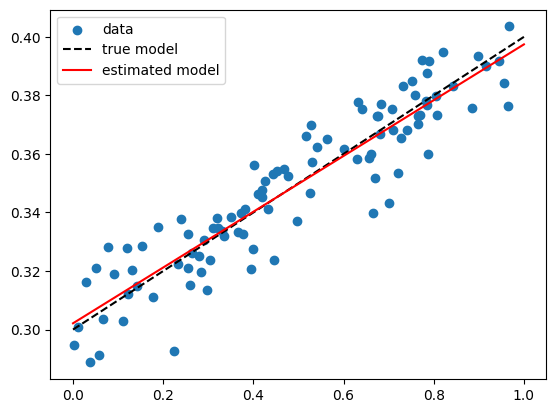

In [15]:
# we have to detach from the graph since otherwise the automatic conversion
# to a numpy array performed by matplotlib will error
phi_numpy = phi.detach().numpy()
print(phi_numpy)
plt.scatter(x, y, label = 'data')
plt.plot([0, 1], [phi_true[0], phi_true[0] + phi_true[1]], 'k--', label = 'true model')
plt.plot([0, 1], [phi_numpy[0], phi_numpy[0] + phi_numpy[1]], 'r-', label = 'estimated model')
plt.legend()
plt.show()

# Part II: Classification of hand written digits with PyTorch

In Hand-in Assignment 1, you implemented a neural network for MNIST classification using NumPy. In this task, you will re-implement the same model using the PyTorch API. By keeping all hyperparameters identical, you should expect to obtain the same results as in your NumPy-based implementation.

### Step-1: Load and normalize the MNIST training and test datasets using `torchvision`.

In this step, we use the `torchvision` dataset and transform APIs to load and normalize MNIST, and the `DataLoader` to efficiently batch and iterate over the data during training and evaluation. Specifically, `torchvision.datasets.MNIST` provides a ready-to-use wrapper that automatically handles downloading, caching, and accessing the dataset, returning image–label pairs in a PyTorch-friendly format.

In [16]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torchvision.transforms import v2 as T


seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

# T.Compose takes a list of transformations and applies them in sequence
transform = T.Compose([
    T.PILToTensor(),
    T.ToDtype(torch.float32, scale=True), # scale=True scales values to the interval [0,1] if needed
])
# Notice the new keyword argument added at the end!
trainset = MNIST(
    './data',
    train=True,
    download=True,
    transform=transform)

testset = MNIST(
    './data',
    train=False,
    download=True,
    transform=transform)

# extract a complete PyTorch dataset
def extract(dataset):
    datasize = len(dataset)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=datasize, shuffle=False)
    return next(iter(dataloader))

# extract all test images and labels into PyTorch tensors
# the training data will be loaded in batches during training
test_X, test_Y = extract(testset)

# Notice how image is now a tensor
print(test_X.shape)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.07MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 158kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.95MB/s]


torch.Size([10000, 1, 28, 28])


### Step-2: Implement a multi-layer neural network

PyTorch provides the `torch.nn.Module` API to define arbitrary network architectures while tracking all learnable parameters automatically. **You should use this API to implement exactly the same fully-connected network as you designed for Assignment 1.**

Note: The input data $X$ are grayscale images of $28\times 28$ pixels. The first dimension will be the number of data points that are provided to the network. The input data is flattend into a matrix with $28 \times 28 = 784$ columns using `X.view(-1, 784)`, where each colum represents one pixel.

In [17]:
def weight_init(net_l):
    # network initialization function
    if not isinstance(net_l, list):
        net_l = [net_l]
    for net in net_l:
        for m in net.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                m.bias.data.fill_(0.0)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x

        out = self.relu(self.conv1(x))
        out = self.conv2(out)

        out += identity   # residual connection
        out = self.relu(out)

        return out



# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()

#         self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
#         self.pool1 = nn.MaxPool2d(2,2)

#         self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
#         self.pool2 = nn.MaxPool2d(2,2)

#         self.conv3 = nn.Conv2d(16, 32, 3, padding=1)

#         # 加两个残差块（32通道）
#         self.res1 = ResidualBlock(32)
#         self.res2 = ResidualBlock(32)

#         self.relu = nn.ReLU()
#         self.fc = nn.Linear(32*7*7, 10)

#     def forward(self, x):

#         x = self.pool1(self.relu(self.conv1(x)))
#         x = self.pool2(self.relu(self.conv2(x)))

#         x = self.relu(self.conv3(x))

#         # 残差部分
#         x = self.res1(x)
#         x = self.res2(x)

#         x = x.view(x.size(0), -1)
#         x = self.fc(x)

#         return x


# Batch Normalization (BN)
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()

#         self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
#         self.bn1 = nn.BatchNorm2d(8)
#         self.pool1 = nn.MaxPool2d(2,2)

#         self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
#         self.bn2 = nn.BatchNorm2d(16)
#         self.pool2 = nn.MaxPool2d(2,2)

#         self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
#         self.bn3 = nn.BatchNorm2d(32)

#         self.res1 = ResidualBlock(32)
#         self.res2 = ResidualBlock(32)

#         self.relu = nn.ReLU()
#         self.fc = nn.Linear(32*7*7, 10)

#     def forward(self, x):

#         x = self.pool1(self.relu(self.bn1(self.conv1(x))))
#         x = self.pool2(self.relu(self.bn2(self.conv2(x))))

#         x = self.relu(self.bn3(self.conv3(x)))

#         x = self.res1(x)
#         x = self.res2(x)

#         x = x.view(x.size(0), -1)
#         x = self.fc(x)

#         return x
# dropout

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2,2)

        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)

        self.res1 = ResidualBlock(32)
        self.res2 = ResidualBlock(32)

        self.dropout = nn.Dropout(p=0.5)

        self.relu = nn.ReLU()
        self.fc = nn.Linear(32*7*7, 10)

    def forward(self, x):

        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))

        x = self.relu(self.conv3(x))

        x = self.res1(x)
        x = self.res2(x)

        x = x.view(x.size(0), -1)

        x = self.dropout(x)   # ⭐ Dropout 在全连接前

        x = self.fc(x)

        return x

**TODO:**  Compute how many parameters of this neural network?

### Step-3: Loss function and predict function

We define the cross-entropy for the predicted probabilities $G$ (10-dimensional vectors) and the labels $Y$ (integers between 0 and 9). In addition, we use the `argmax` function to take final predictions.

Note: In PyTorch, we use `torch.nn.functional.cross_entropy` which internally applies a softmax to the model logits, so the input should be raw, unnormalized scores rather than probabilities.

In [18]:
def cross_entropy(G, Y):
    # TODO -- implement the cross entropy loss
    # use F.cross_entropy
    # Replace this line!
    # loss = G.mean()
    loss = F.cross_entropy(G, Y)
    return loss


In [19]:
def predict(net, X):
    return net(X).argmax(dim=1)

def accuracy(G, Y):
    return (G.argmax(dim=1) == Y).float().mean()

### Step-4: Train the network

You should adopt the same settings e.g., batch size, the number of iterations, optimizer, learning rate, etc., as you did in Assignment-1 to train the network.

In [20]:
# initialize the test and training error statistics
test_accuracy = []
test_costs = []
test_iter = []
train_accuracy = []
train_costs = []

# initialize the neural network and move it to the GPU if needed
net = Net()
net.to(device)

# define the optimization algorithm
learning_rate = 0.1
# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)
# define the data loader for batches of the training data
batch_size = 256
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, num_workers=2, shuffle=True)

# perform multiple training steps
num_epochs = 20

t = 0 # current iteration
done = False
start_time = time.time()
for epoch in range(num_epochs):
    for (batch_X, batch_Y) in trainloader:
        # move batch to the GPU if needed
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # TODO -- Network forward, loss calculation, and backward!
        # Replace the lines below!
        # batch_G = batch_Y.unsqueeze(1)
        # loss = (batch_G - batch_Y).sum()
        batch_G = net(batch_X)              # 前向传播
        loss = cross_entropy(batch_G, batch_Y)  # 计算损失
        loss.backward()                     # 反向传播


        # perform gradient descent step
        optimizer.step()

        # don't bother too much about the following lines!
        with torch.no_grad():
            # evaluate the performance on the training data at every 100th iteration
            # 更改画图间隔
            if t % 100 == 0:
                train_costs.append(loss.item())
                train_accuracy.append(accuracy(batch_G, batch_Y).item())

            # evaluate the performance on the test data at every 100th iteration
            if t % 100 == 0:
                # move test data to the GPU if needed
                X, Y = test_X.to(device), test_Y.to(device)

                # compute predictions for the test data
                G = net(X)
                test_costs.append(cross_entropy(G, Y).item())
                test_accuracy.append(accuracy(G, Y).item())
                test_iter.append(t)

                # print the iteration number and the accuracy of the predictions
                print(f"Epoch {epoch:2d} - Step {t:5d}: train accuracy {100 * train_accuracy[-1]:6.2f}% " \
                      f"train costs {train_costs[-1]:5.2f}  " \
                      f"test accuracy {100 * test_accuracy[-1]:6.2f}% " \
                      f"test costs {test_costs[-1]:5.2f}")

        # accumulate iterations
        t += 1




end_time = time.time()
elapsed = end_time - start_time
print(f"Elapsed time: {elapsed:.2f} seconds")








Epoch  0 - Step     0: train accuracy  11.72% train costs  2.30  test accuracy  10.35% test costs  2.30
Epoch  0 - Step   100: train accuracy  89.84% train costs  0.34  test accuracy  92.09% test costs  0.25
Epoch  0 - Step   200: train accuracy  94.14% train costs  0.19  test accuracy  95.56% test costs  0.14
Epoch  1 - Step   300: train accuracy  97.27% train costs  0.11  test accuracy  96.89% test costs  0.10
Epoch  1 - Step   400: train accuracy  98.44% train costs  0.07  test accuracy  97.21% test costs  0.09
Epoch  2 - Step   500: train accuracy  98.05% train costs  0.08  test accuracy  97.47% test costs  0.08
Epoch  2 - Step   600: train accuracy  96.88% train costs  0.10  test accuracy  97.81% test costs  0.07
Epoch  2 - Step   700: train accuracy  98.05% train costs  0.07  test accuracy  98.07% test costs  0.06
Epoch  3 - Step   800: train accuracy  99.22% train costs  0.04  test accuracy  98.18% test costs  0.06
Epoch  3 - Step   900: train accuracy  98.05% train costs  0.04 

### Step-5: Evaluation on the test data

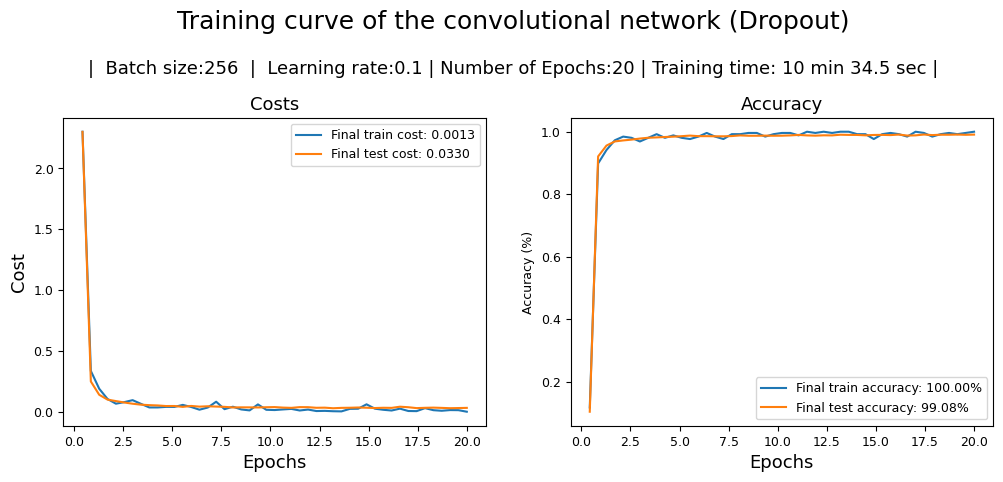

In [21]:
# plot the cross-entropy
def training_curve_plot(title,
                        train_costs, test_costs, train_accuracy, test_accuracy,
                        batch_size, learning_rate, num_epochs, elapsed):
    # Plot training curves in a format recomended for Hand-in assignment 1 and 2
    #
    # Input
    # title - title for the plot
    # train_costs - Array of training costs
    # test_costs - Array of test costs
    # train_accuracies - Array of training accuracies
    # test_accuracies - Array of test accuracies
    # batch_size - batch size for training data used during training
    # num_epochs - Number of epochs used during training
    # elapsed - Time elapsed in seconds during training

    lg=18
    md=13
    sm=9
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(title, y=1.15, fontsize=lg)
    elapsed_min, elapsed_sec = divmod(elapsed, 60)
    sub = f'|  Batch size:{batch_size}  |  Learning rate:{learning_rate} | Number of Epochs:{num_epochs} ' \
                + f'| Training time: {elapsed_min:.0f} min {elapsed_sec:.1f} sec |'
    fig.text(0.5, 0.99, sub, ha='center', fontsize=md)
    x = np.array(range(1, len(train_costs)+1))*num_epochs/len(train_costs)
    axs[0].plot(x, train_costs, label=f'Final train cost: {train_costs[-1]:.4f}')
    axs[0].plot(x, test_costs, label=f'Final test cost: {test_costs[-1]:.4f}')
    axs[0].set_title('Costs', fontsize=md)
    axs[0].set_xlabel('Epochs', fontsize=md)
    axs[0].set_ylabel('Cost', fontsize=md)
    axs[0].legend(fontsize=sm)
    axs[0].tick_params(axis='both', labelsize=sm)
    # Optionally use a logarithmic y-scale
    #axs[0].set_yscale('log')
    axs[1].plot(x, train_accuracy, label=f'Final train accuracy: {100*train_accuracy[-1]:.2f}%')
    axs[1].plot(x, test_accuracy, label=f'Final test accuracy: {100*test_accuracy[-1]:.2f}%')
    axs[1].set_title('Accuracy', fontsize=md)
    axs[1].set_xlabel('Epochs', fontsize=md)
    axs[1].set_ylabel('Accuracy (%)', fontsize=sm)
    axs[1].legend(fontsize=sm)
    axs[1].tick_params(axis='both', labelsize=sm)

title = "Training curve of the convolutional network (Dropout)"
training_curve_plot(title,
                    train_costs, test_costs, train_accuracy, test_accuracy,
                    batch_size, learning_rate, num_epochs, elapsed)

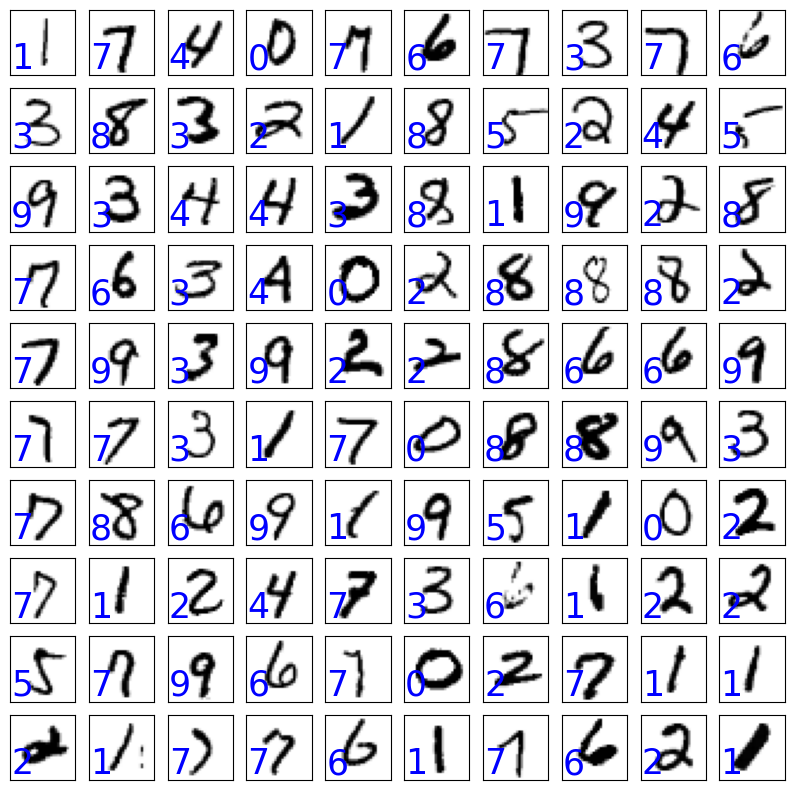

In [22]:
# evaluate the network on 100 random test images
with torch.no_grad():
    # obtain 100 random samples from the test data set
    random_X, random_Y = next(iter(torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True)))

    # move data to the GPU if needed
    random_X, random_Y = random_X.to(device), random_Y.to(device)

    # compute the predictions for the sampled inputs
    random_Yhat = predict(net, random_X)

    # sort the predictions with the incorrect ones first
    indices_incorrect_first = (random_Yhat == random_Y).float().argsort()

# plot the images
num_rows = 10
num_cols = 10
num_images = num_rows * num_cols
plt.figure(figsize=(num_cols, num_rows))

for i, index in enumerate(indices_incorrect_first, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.xticks([])
    plt.yticks([])

    # plot the image
    plt.imshow(random_X[index, :, :].view(28, 28).cpu().numpy(), cmap=plt.cm.binary)

    # add the prediction as annotation (incorrect predictions in red, correct ones in blue)
    color = 'blue' if random_Yhat[index] == random_Y[index] else 'red'
    plt.text(0, 25, random_Yhat[index].item(), fontsize=25, color=color)

plt.show()

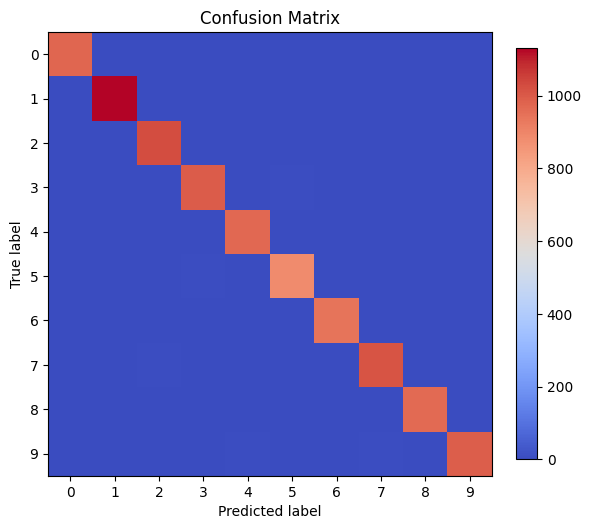

In [23]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_labels, y_preds):
    class_names = np.arange(10) # for MNIST labels
    cm = confusion_matrix(y_labels, y_preds).astype(np.float64)

    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap='coolwarm')
    plt.title("Confusion Matrix")
    plt.colorbar(shrink=0.75, fraction=0.05)

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    plt.tight_layout()
    plt.show()

with torch.no_grad():
    y_preds = predict(net, test_X.to(device)).cpu().numpy()
    y_labels = test_Y.to(device).cpu().numpy()

plot_confusion_matrix(y_labels, y_preds)

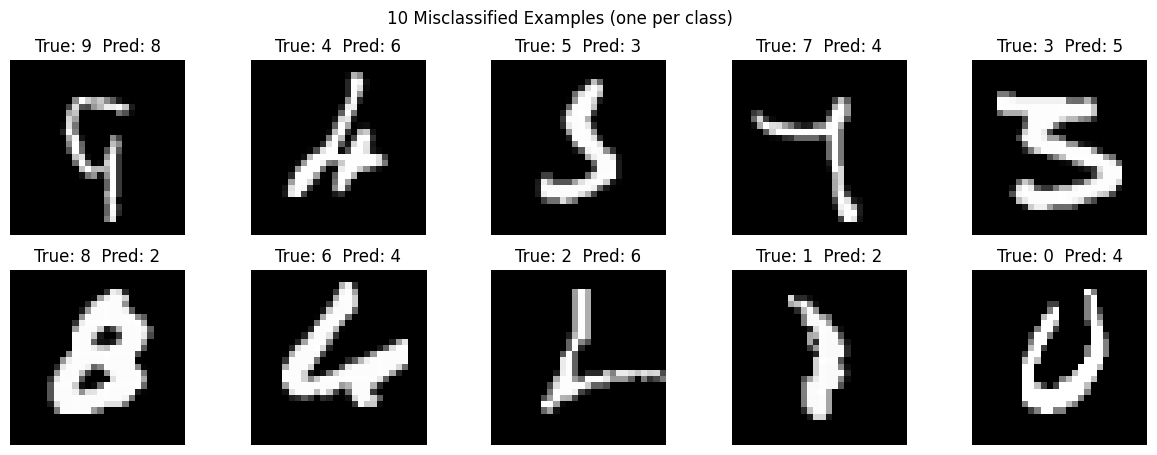

In [28]:
# =========================
# Step-6: Visualize 10 misclassified examples (one per class)
# =========================
with torch.no_grad():
    # move test data to device
    test_X_device = test_X.to(device)
    test_Y_device = test_Y.to(device)

    # get predictions for the test set
    y_preds = net(test_X_device).argmax(dim=1)

    # find misclassified indices
    misclassified_indices = (y_preds != test_Y_device).nonzero(as_tuple=True)[0]

    # collect one misclassified example per class
    misclassified_per_class = {}
    for idx in misclassified_indices:
        true_label = test_Y_device[idx].item()
        if true_label not in misclassified_per_class:
            misclassified_per_class[true_label] = idx
        if len(misclassified_per_class) == 10:
            break

    # plot the 10 misclassified examples
    plt.figure(figsize=(15, 5))
    for i, (cls, idx) in enumerate(misclassified_per_class.items()):
        plt.subplot(2, 5, i+1)
        plt.imshow(test_X_device[idx].cpu().view(28, 28), cmap='gray')
        plt.title(f"True: {cls}  Pred: {y_preds[idx].item()}")
        plt.axis('off')
    plt.suptitle("10 Misclassified Examples (one per class)")
    plt.show()

In [25]:
# ======================================================
# NumPy Implementation for MNIST (for fair comparison)
# ======================================================

import numpy as np
import time
import random

# =========================
# 1. Seed
# =========================
seed = 42
np.random.seed(seed)
random.seed(seed)

# =========================
# 2. Extract all data from PyTorch dataset
# =========================
def extract_all(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    X, Y = next(iter(loader))
    return X, Y

# 提取训练和测试数据
X_train, Y_train = extract_all(trainset)
X_test, Y_test = extract_all(testset)

# 转为 NumPy
X_train_np = X_train.numpy().reshape(-1, 784)   # flatten 28x28 -> 784
X_test_np  = X_test.numpy().reshape(-1, 784)

# 标签转为 one-hot
def to_one_hot(y, num_classes=10):
    return np.eye(num_classes)[y]

Y_train_np = to_one_hot(Y_train.numpy())
Y_test_np  = to_one_hot(Y_test.numpy())

# =========================
# 3. Initialize (He initialization)
# =========================
def initialize(model):
    weights = []
    biases = []
    for k in range(len(model)-1):
        W = np.random.randn(model[k+1], model[k]) * np.sqrt(2.0 / model[k])
        b = np.zeros((model[k+1], 1))
        weights.append(W)
        biases.append(b)
    return weights, biases

# =========================
# 4. Activation functions
# =========================
def ReLU(x):
    return np.maximum(0, x)

def d_ReLU(x):
    return (x > 0).astype(float)

# =========================
# 5. Forward pass
# =========================
def forward_pass(X, weights, biases):
    A = X
    activations = [A]
    pre_activations = []

    for k in range(len(weights)-1):
        Z = A @ weights[k].T + biases[k].T
        A = ReLU(Z)
        pre_activations.append(Z)
        activations.append(A)

    Z = A @ weights[-1].T + biases[-1].T
    pre_activations.append(Z)

    return Z, pre_activations, activations

# =========================
# 6. Softmax + Cross-Entropy
# =========================
def softmax(f):
    f_shift = f - np.max(f, axis=1, keepdims=True)
    exp_f = np.exp(f_shift)
    return exp_f / np.sum(exp_f, axis=1, keepdims=True)

def compute_cost(f, y):
    p = softmax(f)
    return -np.mean(np.sum(y * np.log(p + 1e-12), axis=1))

def d_cost_d_output(f, y):
    p = softmax(f)
    return (p - y) / y.shape[0]

# =========================
# 7. Backward pass
# =========================
def backward_pass(weights, biases, pre_activations, activations, y):
    K = len(weights)
    dW = [None] * K
    db = [None] * K

    df = d_cost_d_output(pre_activations[-1], y)

    for k in reversed(range(K)):
        dW[k] = df.T @ activations[k]
        db[k] = np.sum(df, axis=0, keepdims=True).T

        if k > 0:
            df = (df @ weights[k]) * d_ReLU(pre_activations[k-1])

    return dW, db

# =========================
# 8. Update parameters
# =========================
def update_parameters(weights, biases, dW, db, lr):
    for k in range(len(weights)):
        weights[k] -= lr * dW[k]
        biases[k]  -= lr * db[k]

# =========================
# 9. Predict
# =========================
def predict(X, y, weights, biases):
    f, _, _ = forward_pass(X, weights, biases)
    probs = softmax(f)

    predictions = np.argmax(probs, axis=1)
    labels = np.argmax(y, axis=1)

    accuracy = np.mean(predictions == labels)
    cost = compute_cost(f, y)

    return accuracy, cost

# =========================
# 10. Mini-batch generator
# =========================
def random_mini_batches(X, Y, batch_size):
    m = X.shape[0]
    perm = np.random.permutation(m)
    X = X[perm]
    Y = Y[perm]

    mini_batches = []
    for i in range(0, m, batch_size):
        mini_batches.append((X[i:i+batch_size], Y[i:i+batch_size]))

    return mini_batches

# =========================
# 11. Train NumPy model
# =========================
def train_numpy_model(X_train, Y_train, X_test, Y_test):
    model = [784, 256, 128, 64, 32, 16, 10]
    num_epochs = 50
    learning_rate = 0.1
    batch_size = 128

    weights, biases = initialize(model)


    train_costs, test_costs = [], []
    train_accs, test_accs = [], []

    start_time = time.time()

    for epoch in range(num_epochs):
        mini_batches = random_mini_batches(X_train, Y_train, batch_size)
        for X_mini, Y_mini in mini_batches:
            f, pre, act = forward_pass(X_mini, weights, biases)
            dW, db = backward_pass(weights, biases, pre, act, Y_mini)
            update_parameters(weights, biases, dW, db, learning_rate)

        acc_tr, cost_tr = predict(X_train, Y_train, weights, biases)
        acc_te, cost_te = predict(X_test, Y_test, weights, biases)

        train_costs.append(cost_tr)
        test_costs.append(cost_te)
        train_accs.append(acc_tr)
        test_accs.append(acc_te)

        print(
            f"[NumPy] Epoch {epoch:3d} | "
            f"Train acc {acc_tr:.4f} | Test acc {acc_te:.4f}"
        )

    elapsed = time.time() - start_time

    print("\n===== NumPy Final Results =====")
    print(f"Final Train Accuracy: {train_accs[-1]*100:.2f}%")
    print(f"Final Test Accuracy: {test_accs[-1]*100:.2f}%")
    print(f"Elapsed time: {elapsed:.2f} seconds")

    # 可选：绘制训练曲线
    training_curve_plot(
        "NumPy Implementation",
        train_costs,
        test_costs,
        train_accs,
        test_accs,
        batch_size,
        learning_rate,
        num_epochs,
        elapsed
    )

# =========================
# 12. Run NumPy model
# =========================
train_numpy_model(X_train_np, Y_train_np, X_test_np, Y_test_np)


[NumPy] Epoch   0 | Train acc 0.9399 | Test acc 0.9358
[NumPy] Epoch   1 | Train acc 0.9710 | Test acc 0.9631
[NumPy] Epoch   2 | Train acc 0.9799 | Test acc 0.9690
[NumPy] Epoch   3 | Train acc 0.9832 | Test acc 0.9710
[NumPy] Epoch   4 | Train acc 0.9868 | Test acc 0.9730
[NumPy] Epoch   5 | Train acc 0.9919 | Test acc 0.9751
[NumPy] Epoch   6 | Train acc 0.9907 | Test acc 0.9718
[NumPy] Epoch   7 | Train acc 0.9945 | Test acc 0.9761
[NumPy] Epoch   8 | Train acc 0.9913 | Test acc 0.9722
[NumPy] Epoch   9 | Train acc 0.9963 | Test acc 0.9768
[NumPy] Epoch  10 | Train acc 0.9988 | Test acc 0.9777
[NumPy] Epoch  11 | Train acc 0.9987 | Test acc 0.9791
[NumPy] Epoch  12 | Train acc 0.9971 | Test acc 0.9765
[NumPy] Epoch  13 | Train acc 0.9998 | Test acc 0.9813
[NumPy] Epoch  14 | Train acc 0.9999 | Test acc 0.9815
[NumPy] Epoch  15 | Train acc 0.9999 | Test acc 0.9809
[NumPy] Epoch  16 | Train acc 0.9999 | Test acc 0.9826
[NumPy] Epoch  17 | Train acc 1.0000 | Test acc 0.9814
[NumPy] Ep

KeyboardInterrupt: 